In [6]:
import random

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from gMLV import *

In [7]:
def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)

In [8]:
# some plotting functions

cols = ["red", "green", "blue", "royalblue","orange", "black", "salmon", "forestgreen", "steelblue", "slateblue","gold", "palegreen"]

def plot_gMLV(yobs, sobs, timepoints):
    #fig, axs = plt.subplots(1, 2, layout='constrained')
    fig, axs = plt.subplots(1, 2)
    for species_idx in range(yobs.shape[1]):
        axs[0].plot(timepoints, yobs[:, species_idx], color=cols[species_idx])
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('[species]')
    if sobs.shape[1] > 0:
        for metabolite_idx in range(sobs.shape[1]):
            axs[1].plot(timepoints, sobs[:, metabolite_idx], color=cols[metabolite_idx])
        axs[1].set_xlabel('time')
        axs[1].set_ylabel('[metabolite]');

def plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, timepoints):
    # plot the fit
    #fig, axs = plt.subplots(1, 2, layout='constrained')
    fig, axs = plt.subplots(1, 2)  
    for species_idx in range(yobs.shape[1]):
        axs[0].plot(timepoints, yobs[:, species_idx], color=cols[species_idx])
        axs[0].plot(timepoints, yobs_h[:, species_idx], '--', color=cols[species_idx])
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('[species]');

    for metabolite_idx in range(sobs.shape[1]):
        axs[1].plot(timepoints, sobs[:, metabolite_idx], color=cols[metabolite_idx])
        axs[1].plot(timepoints, sobs_h[:, metabolite_idx], '--', color=cols[metabolite_idx])
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('[metabolite]');

def compare_params(mu=None, M=None, alpha=None, e=None):
    # each argument is a tuple of true and predicted values
    if mu is not None:
        print("mu_hat/mu:")
        print(np.array(mu[1]))
        print(np.array(mu[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0,len(mu[0]), dtype="int32"), np.array(mu[1]), markerfmt="D")
        ax.stem(np.arange(0,len(mu[0]), dtype="int32"), np.array(mu[0]), markerfmt="X")
        ax.set_xlabel('i')
        ax.set_ylabel('mu[i]');

    if M is not None:
        print("\nM_hat/M:")
        print(np.round(np.array(M[1]), decimals=2))
        print("\n",np.array(M[0]))

        #fig, ax = plt.subplots()
        #ax.stem(np.arange(0, M[0].shape[0] ** 2), np.array(M[1]).flatten(), markerfmt="D")
        #ax.stem(np.arange(0, M[0].shape[0] ** 2), np.array(M[0]).flatten(), markerfmt="X")
        #ax.set_ylabel('M[i,j]');

        fig, ax = plt.subplots()
        Ns = M[0].shape[0]
        ax.stem(np.arange(0, Ns), np.array(M[1]).diagonal(), markerfmt="D")
        ax.stem(np.arange(0, Ns), np.array(M[0]).diagonal(), markerfmt="X")
        ax.set_ylabel('M[i,i]');
        
        fig, ax = plt.subplots()
        Ns = M[0].shape[0]
        
        count = 0
        Mij = np.zeros([Ns*Ns - Ns])
        Mij_h = np.zeros([Ns*Ns - Ns])
        for i in range(Ns):
            for j in range(Ns):
                if i != j:
                    Mij[count] = np.array(M[0])[i,j]
                    Mij_h[count] = np.array(M[1])[i,j]
                    count = count + 1
        
        ax.stem(np.arange(0, Ns*Ns - Ns), Mij.flatten(), markerfmt="D")
        ax.stem(np.arange(0, Ns*Ns - Ns), Mij_h.flatten(), markerfmt="X")
        ax.set_ylabel('M[i,i]');
        
    if alpha is not None:
        print("\na_hat/a:")
        print(np.round(np.array(alpha[1]), decimals=2))
        print("\n",np.array(alpha[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, alpha[0].shape[0] * alpha[0].shape[1]), np.array(alpha[1]).flatten(), markerfmt="D")
        ax.stem(np.arange(0, alpha[0].shape[0] * alpha[0].shape[1]), np.array(alpha[0]).flatten(), markerfmt="X")
        ax.set_ylabel('a[i,j]');

    if e is not None:
        print("\ne_hat/e:")
        print(np.round(np.array(e[1]), decimals=2))
        print("\n",np.array(e[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, e[0].shape[0]), np.array(e[1]).flatten(), markerfmt="D")
        ax.stem(np.arange(0, e[0].shape[0]), np.array(e[0]).flatten(), markerfmt="X")
        ax.set_ylabel('e[i]');


In [9]:
# some MCMC analysis functions

def make_trace_plot(var,istart,iend):
    plt.figure()
    post = df[var][istart:iend]
    plt.plot(range(0,(iend-istart)),post)
    #print(var, np.median(post))
    return
    
def make_hist_plot(var,istart,iend):
    plt.figure()
    post = df[var][istart:iend]
    plt.hist(post)
    print(var, np.median(post))
    return
    
def get_Rhat(N,p1,p2):
    M = 2
    mean1 = np.mean(p1,axis=0)  
    mean2 = np.mean(p2,axis=0)  
    var1 = np.var(p1,axis=0)  
    var2 = np.var(p2,axis=0)
    
    meanM = (1/M)*(mean1 + mean2)
    
    B = (N/(M-1)) * (mean1-meanM)*(mean1-meanM) + (mean2-meanM)*(mean2-meanM)
    W = (1/M)*(var1 + var2)
    
    Vhat = ((N-1)/N)*W + ((M+1)/(M*N))*B
    
    Rhat = Vhat/W
    
    return Rhat

def get_horseshoe_tau(p0,D,sigma,n):
    return p0*sigma/( np.sqrt(n)*(D-p0) )

# Single time course: three species

number of species: 3
specific growth rates: [1.27853844 0.55683415 2.06752757]
interaction matrix: 
[[-0.05  0.   -0.1 ]
 [ 0.   -0.1   0.  ]
 [ 0.1   0.   -0.15]]
metabolite production: 
None
perturbation matrix: 
[]


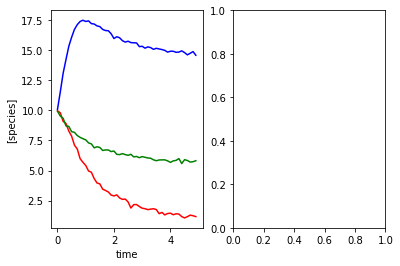

In [5]:
set_all_seeds(1234)

## SETUP MODEL
# establish size of model
num_species = 3
num_metabolites = 0

# construct interaction matrix
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15])
M[0, 2] = -0.1
M[2, 0] = 0.1

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu)
simulator.print()

## PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

# add some gaussian noise
yobs_x = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
plot_gMLV(yobs_x, sobs, times)

# add some gaussian noise on log scale
#yobs_lnx = np.log(yobs) + np.random.normal(loc=0, scale=0.01, size=yobs.shape)
#plot_gMLV(yobs_lnx, sobs, times)


## Full Bayesian inference using ODEs

Text(0.5, 1.0, 'M[i,j]')

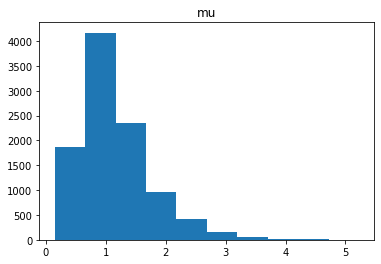

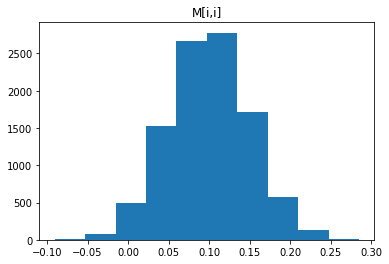

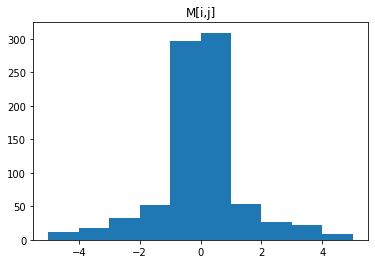

In [6]:
# Prior visualisation
# mu
x_mu = np.random.lognormal(0.01,0.5,size=10000)
plt.figure()
plt.hist(x_mu);
plt.title('mu')   

# Md
x_Md = np.random.normal(0.1,0.05,size=10000)
plt.figure()
plt.hist(x_Md);
plt.title('M[i,i]')    
    
# Shrinkage, M
tau0 = 0.001;
x_M = np.zeros([1000])
for i in range(1000):
    tau = np.random.standard_cauchy(size=1)
    lam = np.random.standard_cauchy(size=1)
    x_M[i] = np.random.normal(0,np.abs(lam)*np.abs(tau),size=1)
#print(x_M)
plt.figure()
plt.hist(x_M, range=(-5,5));
plt.title('M[i,j]')   

In [13]:
import nest_asyncio
nest_asyncio.apply()
import stan

gLV_code = """
functions {
   vector lotka_volterra(real t, vector y, vector mu, vector Md, vector M) {
     vector[2] dydt;
     dydt[1] = mu[1]*y[1] - Md[1]*y[1]*y[1] + M[1]*y[1]*y[2];
     dydt[2] = mu[2]*y[2] - Md[2]*y[2]*y[2] + M[2]*y[2]*y[1];
     return dydt;
  }

  vector lotka_volterra_dln(real t, vector y, vector mu, vector Md, vector M) {
     vector[2] dydt;
     dydt[1] = mu[1] - Md[1]*y[1] + M[1]*y[2];
     dydt[2] = mu[2] - Md[2]*y[2] + M[2]*y[1];
     return dydt;
  }

  vector lotka_volterra_N(real t, vector y, int N, vector mu, vector Md, vector M) {
     vector[N] dydt;
     
     int countM = 1;
     
     for(i in 1:N){
        dydt[i] = mu[i]*y[i] - Md[i]*y[i]*y[i];
        
        for(j in 1:N){
            if ( i != j ){
                dydt[i] += M[countM]*y[i]*y[j];
                countM += 1; 
                //print("loop iteration: ", i, j, countM);
             }
         }
     }
     
     return dydt;
  }


}

data {
  int<lower=1> N;
  int<lower=1> T;
  real t0;
  array[T] real ts;
  array[T,N] real y;
  vector[N] y0;
  real sigma;
  //real tau;
  
  //vector[2] M;
  //vector[2] Md;
}

parameters {
  vector<lower=0>[N]  mu;
  vector<lower=0>[N]  Md;
  vector[N*N - N]     M;
   
  vector<lower=0>[N*N - N]  lambda;
  real<lower=0>  tau;
  
  //vector[N]  y0;
  //real<lower=0>     sigma;
}

model {
  //target += double_exponential_lpdf(mu | 0, 1.0);
  //target += double_exponential_lpdf(Md | 0, 0.1);
  
  //target += normal_lpdf(mu | 1.0, 0.2);
  target += lognormal_lpdf(mu | 0.01, 0.5);
  
  target += normal_lpdf(Md | 0.1, 0.02);
  
  // Laplace
  //target += double_exponential_lpdf(M | 0, 0.1);

  // exponential / normal
  //target += exponential_lpdf(lambda | 10);
  //target += normal_lpdf(M | 0, lambda);

  // hierarchical exponential
  //for(i in 1:2){
  //    target += exponential_lpdf(lambda[i] | 10); // parameterised as 1/scale
  //    target += normal_lpdf(M[i] | 0, lambda[i]);
  //}
  
  // Horsehoe prior
  real tau0 = 0.001;
  target += cauchy_lpdf(tau | 0, tau0);

  for(i in 1:(N*(N-1))){
        target += normal_lpdf(M[i] | 0, lambda[i]*tau);
        target += cauchy_lpdf(lambda[i] | 0, 1);
  }
  
  vector[N] y_hat[T] = ode_bdf_tol(lotka_volterra_N, y0, t0, ts, 1e-6, 1e-6, 100000, N, mu, Md, M );

  for (t in 1:T) {
      for (s in 1:N){
        target += normal_lpdf(y[t,s] | y_hat[t,s],sigma);
      }
    }
}

"""

#obs_data_log = {"T": len(times)-1,
#                "t0": 0.0,
#                "ts": times[1:],   
#                "y": yobs_lnx[1:,:],
#                "y0": np.log(init_species),
#                "sigma": 0.01,
#                #"Md": np.array([-M[0,0],-M[1,1] ]),
#                #"M": np.array( [M[0,1],M[1,0]] )
#               } 

obs_data = {"N": 3,
            "T": len(times)-1,
            "t0": 0.0,
            "ts": times[1:],   
            "y": yobs_x[1:,:],
            "y0": init_species,
            "sigma": 0.1,
            #"tau:": 1.0
            #"Md": np.array([-M[0,0],-M[1,1] ]),
            #"M": np.array( [M[0,1],M[1,0]] )
           } 

#posterior = stan.build(gLV_code, data=obs_data_log, random_seed=1)
posterior = stan.build(gLV_code, data=obs_data, random_seed=1)

NameError: name 'times' is not defined

In [8]:
sample_kwargs = {"num_samples": 500, "num_chains": 2, "num_warmup": 5000 }
#fit = posterior.sample(num_chains=2, num_samples=500, num_warmup=10000, adapt={'delta':0.99})
fit = posterior.sample(**sample_kwargs)

#print(fit)

df = fit.to_frame()
print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
#post1 = np.random.normal(size=500)
#post2 = np.random.normal(size=500)
Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
istart = 0
iend = 1000

Sampling:   0%
Sampling:   0% (1/11000)
Sampling:   0% (2/11000)
Sampling:   1% (101/11000)
Sampling:   2% (200/11000)
Sampling:   3% (300/11000)
Sampling:   4% (400/11000)
Sampling:   5% (500/11000)
Sampling:   5% (600/11000)
Sampling:   6% (700/11000)
Sampling:   7% (800/11000)
Sampling:   8% (900/11000)
Sampling:   9% (1000/11000)
Sampling:  10% (1100/11000)
Sampling:  11% (1200/11000)
Sampling:  12% (1300/11000)
Sampling:  13% (1400/11000)
Sampling:  14% (1500/11000)
Sampling:  15% (1600/11000)
Sampling:  15% (1700/11000)
Sampling:  16% (1800/11000)
Sampling:  17% (1900/11000)
Sampling:  18% (2000/11000)
Sampling:  19% (2100/11000)
Sampling:  20% (2200/11000)
Sampling:  21% (2300/11000)
Sampling:  22% (2400/11000)
Sampling:  23% (2500/11000)
Sampling:  24% (2600/11000)
Sampling:  25% (2700/11000)
Sampling:  25% (2800/11000)
Sampling:  26% (2900/11000)
Sampling:  27% (3000/11000)
Sampling:  28% (3100/11000)
Sampling:  29% (3200/11000)
Sampling:  30% (3300/11000)
Sampling:  31% (3400

  Exception: ode_bdf_tol: ode parameters and data[2] is inf, but must be finite! (in '/tmp/httpstan_0ntnjtzg/model_v6qcrrkq.stan', line 97, column 2 to column 100)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: ode_bdf_tol: ode parameters and data[2] is inf, but must be finite! (in '/tmp/httpstan_0ntnjtzg/model_v6qcrrkq.stan', line 97, column 2 to column 100)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: CVODES: CVode At t = 0 and h = 1.54297e-138, the corrector convergence test failed repeatedly or with |h| = hmin. Error code: -4 (in '/tmp/httpstan_0ntnjtzg/model_v6qcrrkq.stan', line 97, column 2 to column 100)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: CVODES: CVode Internal t = 6.69317e-07 and h = 2.84001e-23 are such that t + h = t on the next step. The solver will continue anyway. Error code: 99 (in '/tmp/httpstan_0ntnjtzg/model_v6

                count        mean         std         min         25%  \
parameters                                                              
lp__           1000.0  117.433683    3.692656  102.907785  115.044616   
accept_stat__  1000.0    0.914092    0.112074    0.010149    0.885708   
stepsize__     1000.0    0.006181    0.000596    0.005585    0.005585   
treedepth__    1000.0    8.967000    0.703140    5.000000    9.000000   
n_leapfrog__   1000.0  679.747000  279.227181   37.000000  511.000000   
divergent__    1000.0    0.022000    0.146757    0.000000    0.000000   
energy__       1000.0 -108.030745    4.746861 -120.496056 -111.396687   
mu.1           1000.0    1.038334    0.254799    0.264083    0.843853   
mu.2           1000.0    0.584282    0.079729    0.351767    0.530817   
mu.3           1000.0    2.058561    0.182956    0.752671    2.013040   
Md.1           1000.0    0.067797    0.017203    0.038047    0.052107   
Md.2           1000.0    0.106826    0.012209    0.

mu: [1.27853844 0.55683415 2.06752757]
mu.1 1.0735504503919286
mu.2 0.577177936149171
mu.3 2.080438875628536
Md: [-0.05 -0.1  -0.15]
Md.1 0.06520512994929438
Md.2 0.10476419560401126
Md.3 0.15100562655495003
M.1 0.0355697515549101


/home/neythen/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/neythen/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


M.2 -0.0989240552204592
M.3 0.000649072235231638
M.4 0.000436062108010005
M.5 0.09968803108607185
M.6 0.000602284864370995


/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


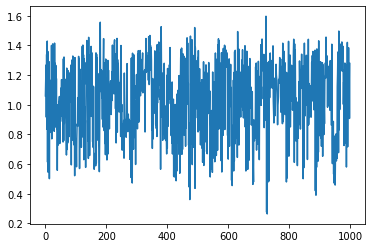

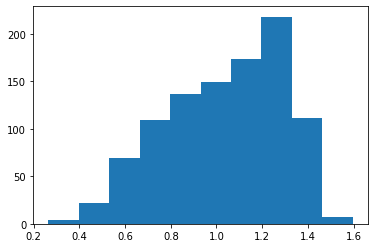

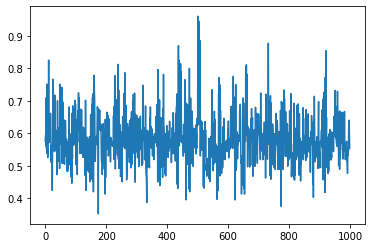

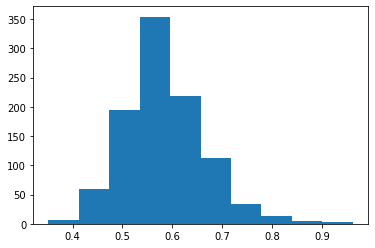

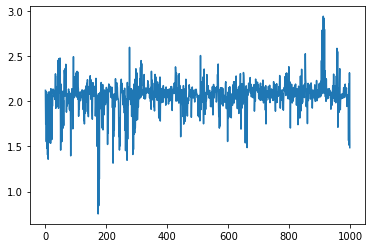

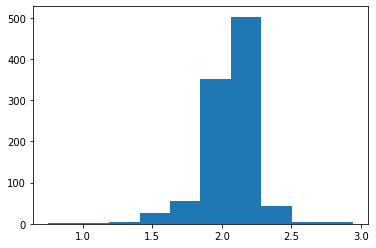

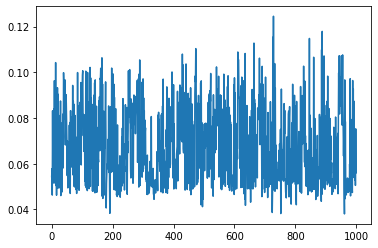

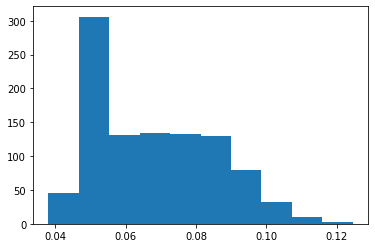

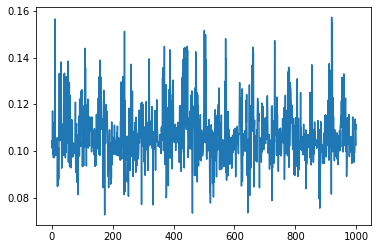

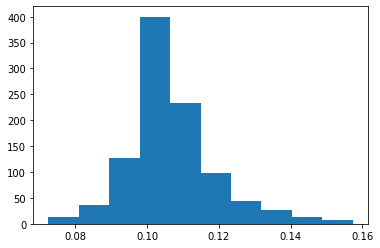

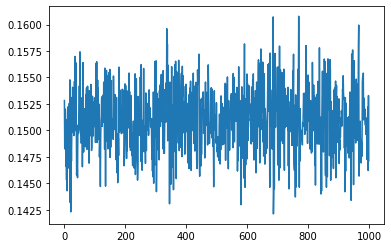

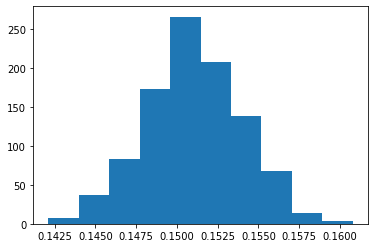

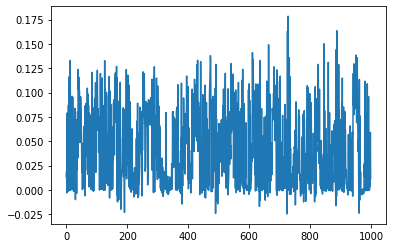

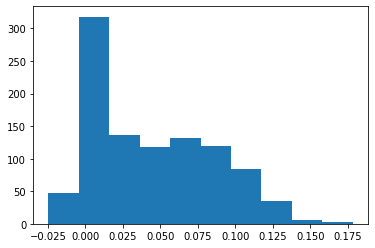

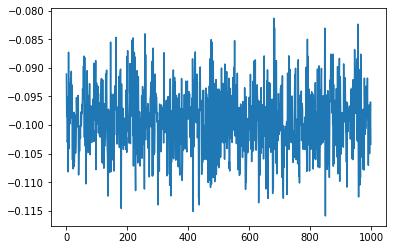

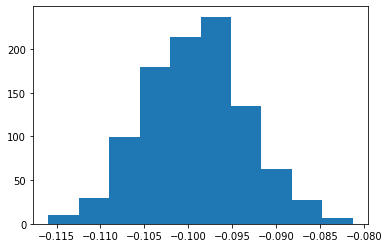

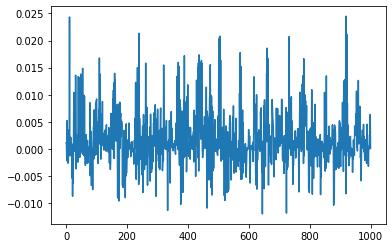

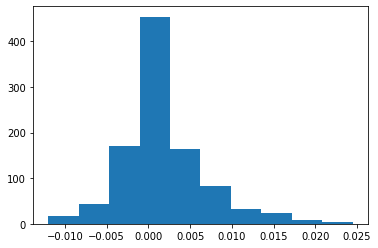

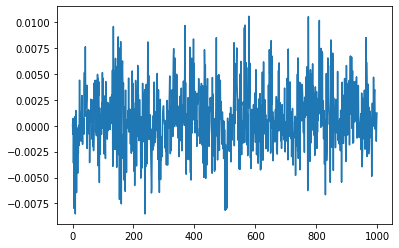

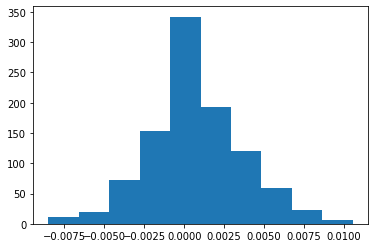

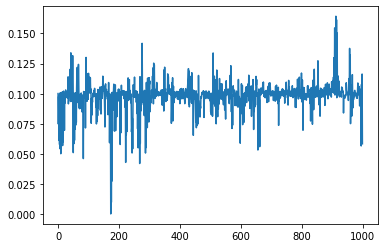

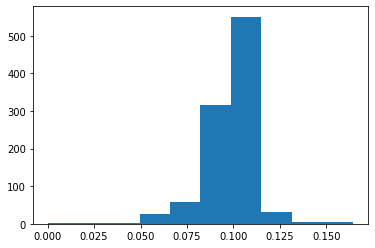

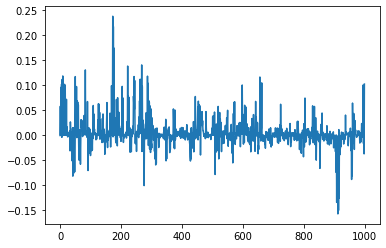

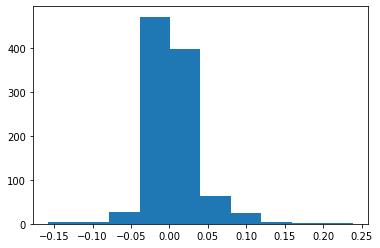

In [9]:
print("mu:",mu)
for i in range(num_species):
    make_trace_plot("mu."+str(i+1),istart,iend)
    make_hist_plot("mu."+str(i+1),istart,iend)


print("Md:",M.diagonal())
for i in range(num_species):
    make_trace_plot("Md."+str(i+1),istart,iend)
    make_hist_plot("Md."+str(i+1),istart,iend)


for i in range( num_species*(num_species - 1)):
    make_trace_plot("M."+str(i+1),istart,iend)
    make_hist_plot("M."+str(i+1),istart,iend)


est: [ 1.07355045e+00  5.77177936e-01  2.08043888e+00  6.52051299e-02
  1.04764196e-01  1.51005627e-01  3.55697516e-02 -9.89240552e-02
  6.49072235e-04  4.36062108e-04  9.96880311e-02  6.02284864e-04
  1.91970196e+00  6.41260220e+00  4.23503528e-01  3.85119833e-01
  6.27127779e+00  8.85267318e-01  1.47299637e-02]
mu_hat/mu:
[1.07355045 0.57717794 2.08043888]
[1.27853844 0.55683415 2.06752757]

M_hat/M:
[[-0.07  0.04 -0.1 ]
 [ 0.   -0.1   0.  ]
 [ 0.1   0.   -0.15]]

 [[-0.05  0.   -0.1 ]
 [ 0.   -0.1   0.  ]
 [ 0.1   0.   -0.15]]


/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance 

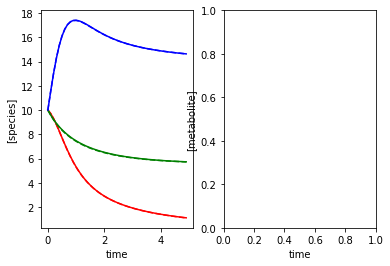

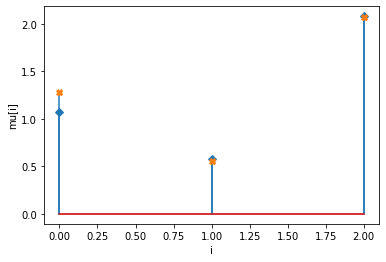

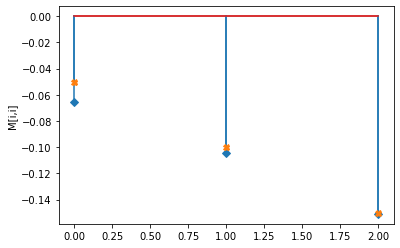

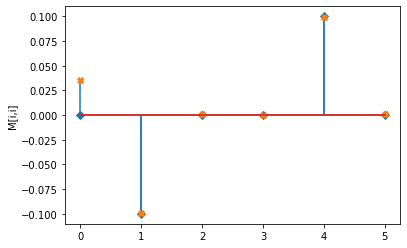

In [10]:
# plot the fit using median values of parameters

post1 = df[df.columns[7:]][0:iend].to_numpy()
est = np.median(post1,axis=0)

# fill mu_h and M-H
mu_h = est[0:num_species]
M_h = np.zeros([num_species,num_species])
np.fill_diagonal(M_h, -est[num_species:2*num_species])

count = 0
print("est:", est)
for i in range(num_species):
    for j in range(num_species):
        if i != j:
            M_h[i,j] = est[2*num_species + count]
            count = count + 1

#print(mu_h)
#print(M_h)

# make the plot and comparison
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu,mu_h), M=(M, M_h))

## Try fitting to one sample

In [15]:
'''
first fit to one sample (M88) which has no perturbations
'''

import os
import sys
import matplotlib.pyplot as plt

sys.path.append( 'data_analysis')
from load_data import *


data = load_subject_ID_dict(trimmed_path = '/home/neythen/Desktop/Projects/gMLV/data/maria_multiomics/processed/trimmed.csv')
X, subjects = get_X_subjects(data) # extract the taxa data ordered by subject and time
perts = load_perturbations_dict(pert_path = '/home/neythen/Desktop/Projects/gMLV/data/maria_multiomics/processed/trimmed.csv')

combined_dict = combine_taxa_pert_dicts(data, perts)


ts = []
X = []
for t, x, p in sorted(combined_dict['M88']):
    
    ts.append(t)
    X.append(x)
    
X = np.array(X)
print(X.shape)
#plt.spy(X)


# remove all species that are 0 at every timepoint 

mask = ~np.all((X == 0), axis =0)

column_indices = np.where(mask)[0]
X = X[:,mask]
print(X.shape)
#plt.figure()
#plt.spy(X)


## SETUP MODEL
# establish size of model
num_species = X.shape[1]
num_metabolites = 0

# construct interaction matrix
M = np.zeros((num_species, num_species))
np.fill_diagonal(M, [-0.05, -0.1, -0.15])
M[0, 2] = -0.1
M[2, 0] = 0.1

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)




obs_data = {"N": X.shape[1],
            "T": len(ts)-1,
            "t0": 0.0,
            "ts": ts[1:],   
            "y": X[1:,:],
            "y0": X[0,:],
            "sigma": 0.1,
            #"tau:": 1.0
            #"Md": np.array([-M[0,0],-M[1,1] ]),
            #"M": np.array( [M[0,1],M[1,0]] )
           } 

#posterior = stan.build(gLV_code, data=obs_data_log, random_seed=1)
posterior = stan.build(gLV_code, data=obs_data, random_seed=1)


sample_kwargs = {"num_samples": 500, "num_chains": 2, "num_warmup": 5000 }
#fit = posterior.sample(num_chains=2, num_samples=500, num_warmup=10000, adapt={'delta':0.99})
fit = posterior.sample(**sample_kwargs)

#print(fit)

df = fit.to_frame()
print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
#post1 = np.random.normal(size=500)
#post2 = np.random.normal(size=500)
Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
istart = 0
iend = 1000

print("mu:",mu)
for i in range(num_species):
    make_trace_plot("mu."+str(i+1),istart,iend)
    make_hist_plot("mu."+str(i+1),istart,iend)


print("Md:",M.diagonal())
for i in range(num_species):
    make_trace_plot("Md."+str(i+1),istart,iend)
    make_hist_plot("Md."+str(i+1),istart,iend)


for i in range( num_species*(num_species - 1)):
    make_trace_plot("M."+str(i+1),istart,iend)
    make_hist_plot("M."+str(i+1),istart,iend)

[]
[]
[]
[]
[]
(20, 94)
(20, 16)
Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_0_opiy5t/model_v6qcrrkq.stan', line 97, column 35: The variable lotka_volterra_N may not have been assigned a value before its use.
Sampling:   0%

RuntimeError: Exception during call to services function: `ValueError("Exception: CVODES: CVode Internal t = 50.1858 and h = 3.47331e-15 are such that t + h = t on the next step. The solver will continue anyway. Error code: 99 (in '/tmp/httpstan_0ntnjtzg/model_v6qcrrkq.stan', line 97, column 2 to column 100)")`, traceback: `['  File "/home/neythen/anaconda3/lib/python3.7/asyncio/tasks.py", line 249, in __step\n    result = coro.send(None)\n', '  File "/home/neythen/anaconda3/lib/python3.7/site-packages/httpstan/services_stub.py", line 160, in call\n    future.result()\n', '  File "/home/neythen/anaconda3/lib/python3.7/asyncio/futures.py", line 178, in result\n    raise self._exception\n']`

## Full Bayesian inference using linear approximation of dynamics

In [11]:
# linearise
X, F = linearize_time_course_16S(yobs_x, times)

#print(X[:,:(X.shape[1]-1)])
X = X[:,:(X.shape[1]-1)]

import nest_asyncio
nest_asyncio.apply()
import stan

gLV_code = """
functions {
  vector lotka_volterra_N_red(real[] x, int N, vector mu, vector Md, vector M) {
     // Models Y = dlnX/dt = f ( X )
     
     vector[N] dydt;
     
     int countM = 1;
     
     for(i in 1:N){
        dydt[i] = mu[i] - Md[i]*x[i];
        
        for(j in 1:N){
            if ( i != j ){
                dydt[i] += M[countM]*x[j];
                countM += 1; 
                //print("loop iteration: ", i, j, countM);
             }
         }
     }
     
     return dydt;
  }

}

data {
  int<lower=1> N;
  int<lower=1> T;
  
  array[T,N] real y;
  array[T,N] real x;
  
  real sigma;

  //vector<lower=0>[N]  mu;
  //vector<lower=0>[N]  Md;
}

parameters {
  vector<lower=0>[N]  mu;
  vector<lower=0>[N]  Md;
  vector[N*N - N]     M;

  vector<lower=0>[N*N - N]  lambda;
  real<lower=0>  tau;
}

model {
  //target += normal_lpdf(mu | 1.0, 0.2);
  target += lognormal_lpdf(mu | 0.01, 0.5);
  
  target += normal_lpdf(Md | 0.1, 0.05);
  
  // Laplace
  //target += double_exponential_lpdf(M | 0, 0.1);

  // Horsehoe prior
  real tau0 = 0.001;
  target += cauchy_lpdf(tau | 0, tau0);

  for(i in 1:(N*(N-1))){
        target += normal_lpdf(M[i] | 0, lambda[i]*tau);
        target += cauchy_lpdf(lambda[i] | 0, 1);
  }

  for (t in 1:T) {
      vector[N] y_hat = lotka_volterra_N_red(x[t,:], N, mu, Md, M);
      for (s in 1:N){
        target += normal_lpdf(y[t,s] | y_hat[s], sigma);
      }
    }
}

"""

obs_data_lin = {"N": 3,
                "T": len(times)-1,   
                "y": F,
                "x": X,
                "sigma": 0.1,
                #"mu": mu,
                #"Md": np.array([-M[0,0],-M[1,1],-M[2,2]]),
                } 

posterior = stan.build(gLV_code, data=obs_data_lin, random_seed=1)

Building...



Building: 23.3s, done.

In [12]:
sample_kwargs = {"num_samples": 1000, "num_chains": 2, "num_warmup": 5000 }
#fit = posterior.sample(num_chains=2, num_samples=500, num_warmup=10000, adapt={'delta':0.99})
fit = posterior.sample(**sample_kwargs)

#print(fit)

df = fit.to_frame()
print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
#post1 = np.random.normal(size=500)
#post2 = np.random.normal(size=500)
Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
istart = 0
iend = 2000

Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3400

  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in '/tmp/httpstan_x1c4xo8w/model_mjoxdnzg.stan', line 70, column 8 to column 56)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in '/tmp/httpstan_x1c4xo8w/model_mjoxdnzg.stan', line 70, column 8 to column 56)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, 

                count         mean         std          min          25%  \
parameters                                                                 
lp__           2000.0 -1166.774642    3.377001 -1182.397101 -1168.820677   
accept_stat__  2000.0     0.923051    0.104009     0.007482     0.900339   
stepsize__     2000.0     0.018728    0.000469     0.018259     0.018259   
treedepth__    2000.0     7.534500    0.617252     4.000000     7.000000   
n_leapfrog__   2000.0   247.936500  107.532577    31.000000   179.750000   
divergent__    2000.0     0.009500    0.097028     0.000000     0.000000   
energy__       2000.0  1176.291720    4.529114  1163.118401  1173.272371   
mu.1           2000.0     0.242487    0.075614     0.074745     0.186961   
mu.2           2000.0     1.147137    0.274798     0.450161     0.946634   
mu.3           2000.0     1.541302    0.424721     0.448673     1.244155   
Md.1           2000.0     0.201747    0.014099     0.149019     0.192593   
Md.2        

/home/neythen/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/neythen/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


mu: [1.27853844 0.55683415 2.06752757]
mu.1 0.2354294822298929
mu.2 1.1356648466037305
mu.3 1.6173400498441022
Md: [-0.05 -0.1  -0.15]
Md.1 0.20157901496719516
Md.2 0.20252358600618933
Md.3 0.13243796008973757
M.1 0.31192927482929844
M.2 -0.13307799568887915
M.3 0.04357827972561585
M.4 -0.0015027250570411885
M.5 0.07306918405147098
M.6 0.03207688071576908


/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


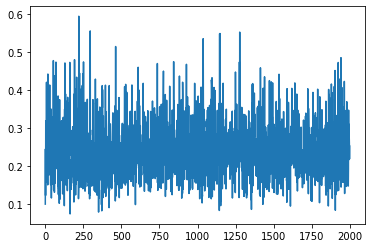

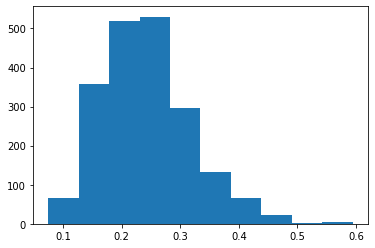

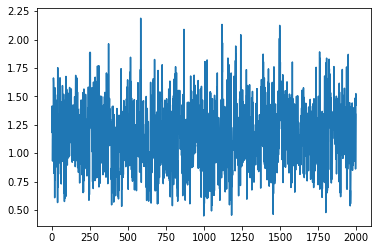

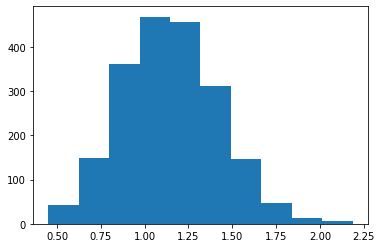

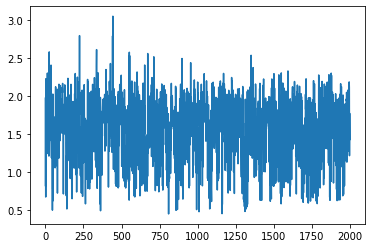

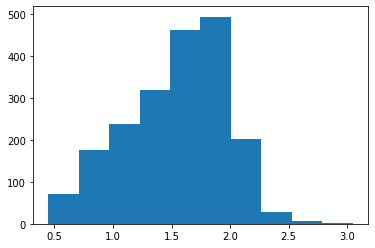

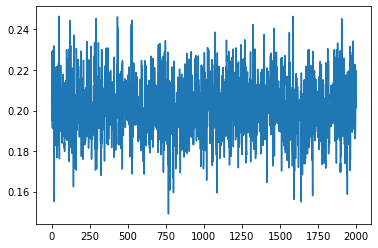

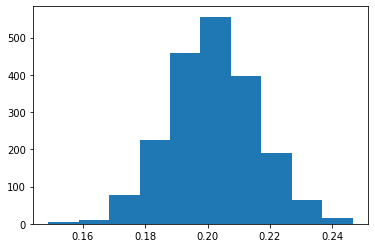

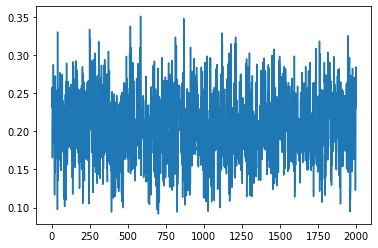

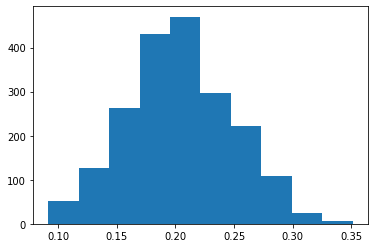

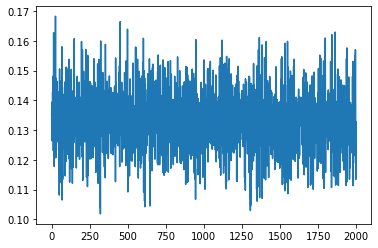

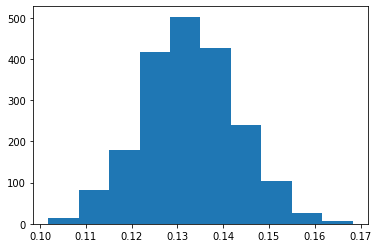

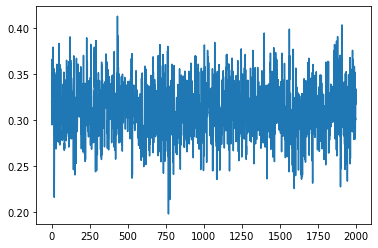

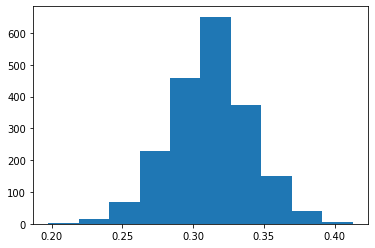

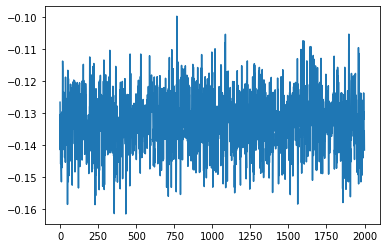

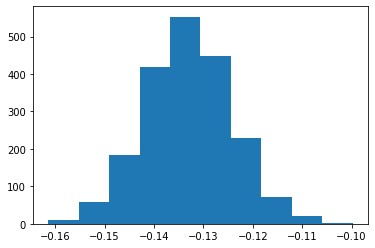

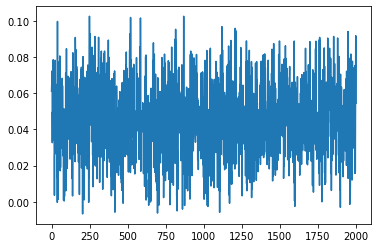

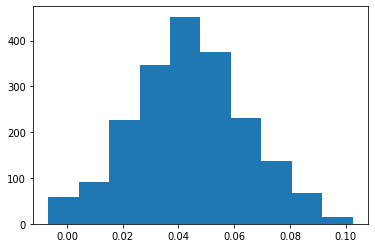

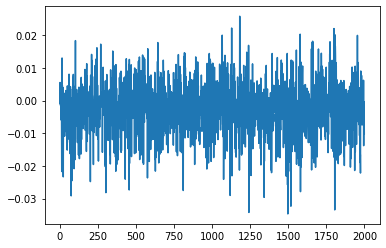

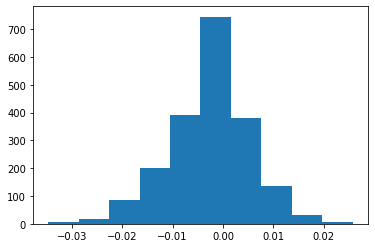

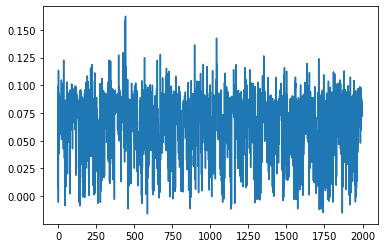

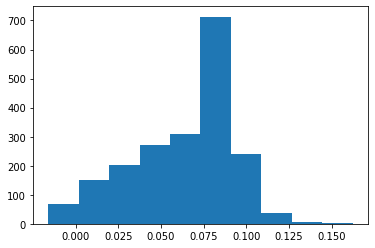

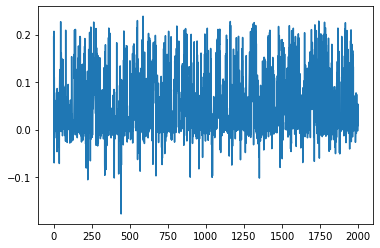

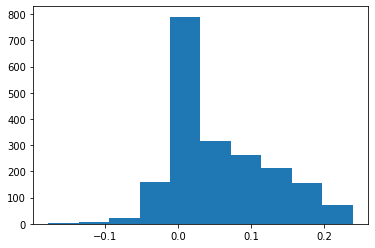

In [13]:
print("mu:",mu)
for i in range(num_species):
    make_trace_plot("mu."+str(i+1),istart,iend)
    make_hist_plot("mu."+str(i+1),istart,iend)


print("Md:",M.diagonal())
for i in range(num_species):
    make_trace_plot("Md."+str(i+1),istart,iend)
    make_hist_plot("Md."+str(i+1),istart,iend)


for i in range( num_species*(num_species - 1)):
    make_trace_plot("M."+str(i+1),istart,iend)
    make_hist_plot("M."+str(i+1),istart,iend)


est: [ 3.11929275e-01 -1.33077996e-01  4.35782797e-02 -1.50272506e-03
  7.30691841e-02  3.20768807e-02  5.18052758e+00  2.48953934e+00
  1.05659903e+00  2.97677805e-01  1.34424114e+00  9.77766819e-01
  5.66967848e-02]
mu_hat/mu:
[0.23542948 1.13566485 1.61734005]
[1.27853844 0.55683415 2.06752757]

M_hat/M:
[[-0.2   0.31 -0.13]
 [ 0.04 -0.2  -0.  ]
 [ 0.07  0.03 -0.13]]

 [[-0.05  0.   -0.1 ]
 [ 0.   -0.1   0.  ]
 [ 0.1   0.   -0.15]]


/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance 

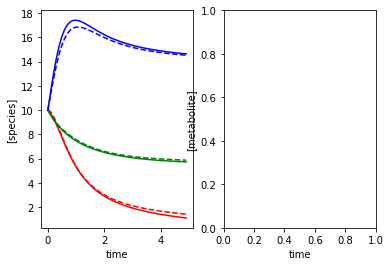

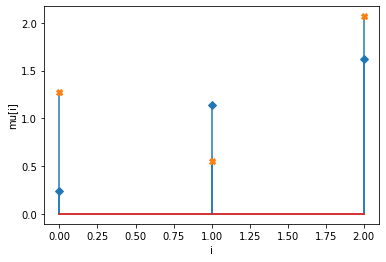

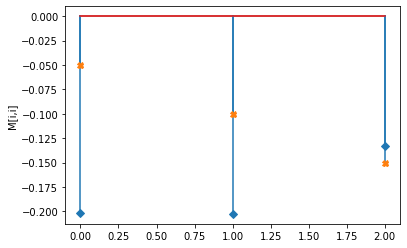

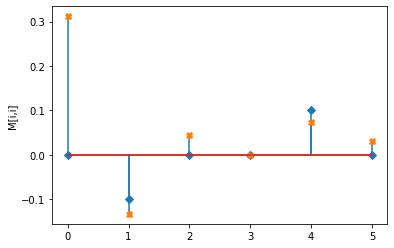

In [14]:
# plot the fit using median values of parameters

post1 = df[df.columns[7:]][0:iend].to_numpy()
est = np.median(post1,axis=0)

# fill mu_h
#mu_h = mu # if mu is fixed
mu_h = est[0:num_species]
est = est[num_species:]

# fill M_h
M_h = np.zeros([num_species,num_species])
#np.fill_diagonal(M_h, M.diagonal() ) # if Md fixed
np.fill_diagonal(M_h, -est[0:num_species])
est = est[num_species:]

count = 0
print("est:", est)
for i in range(num_species):
    for j in range(num_species):
        if i != j:
            #M_h[i,j] = est[2*num_species + count]
            #M_h[i,j] = est[num_species + count]
            M_h[i,j] = est[count]
            count = count + 1

#print(mu_h)
#print(M_h)

# make the plot and comparison
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu,mu_h), M=(M, M_h))

# Single time course: ten species
## Linear approximation of dynamics including a perturbation

number of species: 10
specific growth rates: [1.79502305 1.65859857 1.62687674 0.3676487  0.854671   1.01112056
 1.23704653 1.16712793 1.95536934 0.46605446]
interaction matrix: 
[[-0.12   0.    -0.025  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.04   0.     0.05   0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -0.17   0.     0.     0.     0.     0.     0.    -0.05 ]
 [ 0.     0.     0.    -0.08   0.     0.     0.     0.     0.     0.   ]
 [ 0.02   0.     0.     0.    -0.06   0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.02   0.     0.    -0.14   0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.14   0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.    -0.07   0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.    -0.05   0.    -0.1    0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.    -0.01 ]]
metabolite production: 
None
perturbation matrix: 
[]
(50, 10)


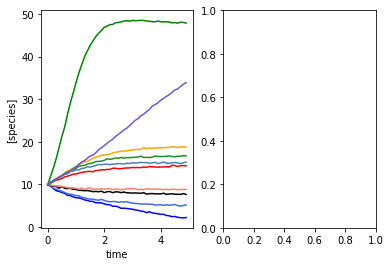

In [15]:
set_all_seeds(1234)

## SETUP MODEL
# establish size of model
num_species = 10
num_metabolites = 0

# construct interaction matrix
#TODO do this programmatically
M = np.zeros((num_species, num_species))

#np.fill_diagonal(M, [-0.05, -0.1, -0.15, -0.01, -0.2, -0.05, -0.1, -0.15, -0.01, -0.2])
np.fill_diagonal(M, -np.round( np.abs( np.random.normal(0.1, 0.05, size=num_species ) ), decimals=2) )

M[0, 2] = -0.025
M[1, 3] = 0.05
M[2, 9] = -0.05
M[4, 0] = 0.02
M[5, 2] = 0.02
M[8, 6] = -0.05

# construct growth rates matrix
mu = np.random.lognormal(0.01, 0.5, num_species)

# construct perturbation matrix: still need to include this
#epsilon = np.array([0, -1, 0 , -1, 0])

# instantiate simulator
simulator = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M,
                     mu=mu) #, epsilon=epsilon)
simulator.print()

## PRODUCE SIMULATED RESULTS
# initial conditions
init_species = 10 * np.ones(num_species)
init_metabolites = 10 * np.ones(num_metabolites)

# perturbation
tp = 2

times = np.arange(0, 5, 0.1)
yobs, sobs, sy0, mu, M, _ = simulator.simulate(times=times, 
                                               sy0=np.hstack((init_species, init_metabolites)) ) #,tp=tp)

# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape)
print(yobs.shape)
# plot simulation
plot_gMLV(yobs, sobs, times)

In [16]:
# linearise
X, F = linearize_time_course_16S(yobs, times)
#print(X[:,:(X.shape[1]-1)])
X = X[:,:(X.shape[1]-1)]

# time dependent perturbation
u = (times >= 2) & (times < 3) 
u = u.astype(int)
u = u[:len(u)-1]
print('perturbation:\n', u)


perturbation:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]


In [17]:
# Horseshoe prior: work out choice for t0
D = (10*10)-10
p0 = 6
n = 50
sigma = 0.1
print( get_horseshoe_tau(p0,D,sigma,n) )

0.0010101525445522109


In [18]:
import nest_asyncio
nest_asyncio.apply()
import stan

gLV_code = """
functions {
  vector lotka_volterra_N_red_u(real[] x, real[] u, int N, vector mu, vector Md, vector M, vector eps) {
     // Models Y = dlnX/dt = f ( X )
     
     vector[N] dydt;
     
     int countM = 1;
     
     for(i in 1:N){
        dydt[i] = mu[i] - Md[i]*x[i];
        
        for(j in 1:N){
            if ( i != j ){
                dydt[i] += M[countM]*x[j];
                countM += 1; 
                //print("loop iteration: ", i, j, countM);
             }
         }
     }
     
     return dydt;
  }

  vector lotka_volterra_N_red(real[] x, int N, vector mu, vector Md, vector M) {
     // Models Y = dlnX/dt = f ( X )
     
     vector[N] dydt;
     
     int countM = 1;
     
     for(i in 1:N){
        dydt[i] = mu[i] - Md[i]*x[i];
        
        for(j in 1:N){
            if ( i != j ){
                dydt[i] += M[countM]*x[j];
                countM += 1; 
                //print("loop iteration: ", i, j, countM);
             }
         }
     }
     
     return dydt;
  }

}

data {
  int<lower=1> N;
  int<lower=1> T;
  
  array[T,N] real y;
  array[T,N] real x;
  
  real sigma;

  //vector<lower=0>[N]  mu;
  //vector<lower=0>[N]  Md;
}

parameters {
  vector<lower=0>[N]  mu;
  vector<lower=0>[N]  Md;
  vector[N*N - N]     M;

  vector<lower=0>[N*N - N]  lambda;
  real<lower=0>  tau;
}

model {
  //target += normal_lpdf(mu | 1.0, 0.2);
  target += lognormal_lpdf(mu | 0.01, 0.5);
  
  target += normal_lpdf(Md | 0.1, 0.05);
  
  // Laplace
  //target += double_exponential_lpdf(M | 0, 0.1);

  // Horsehoe prior
  real tau0 = 0.001;
  //real tau0 = 0.01;
  target += cauchy_lpdf(tau | 0, tau0);

  for(i in 1:(N*(N-1))){
        target += normal_lpdf(M[i] | 0, lambda[i]*tau);
        target += cauchy_lpdf(lambda[i] | 0, 1);
  }

  for (t in 1:T) {
      vector[N] y_hat = lotka_volterra_N_red(x[t,:], N, mu, Md, M);
      for (s in 1:N){
        target += normal_lpdf(y[t,s] | y_hat[s], sigma);
      }
    }
}

"""

obs_data_lin = {"N": 10,
                "T": len(times)-1,   
                "y": F,
                "x": X,
                "sigma": 0.1,
                #"mu": mu,
                #"Md": np.array([-M[0,0],-M[1,1],-M[2,2]]),
                } 

posterior = stan.build(gLV_code, data=obs_data_lin, random_seed=1)

Building...



Building: 23.4s, done.

In [19]:
sample_kwargs = {"num_samples": 1000, "num_chains": 2, "num_warmup": 5000 }
fit = posterior.sample(**sample_kwargs)

#print(fit)

df = fit.to_frame()
print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
#post1 = np.random.normal(size=500)
#post2 = np.random.normal(size=500)

Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
print("max Rhat:", np.max(Rhat))
istart = 0
iend = 2000

Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  19% (2300/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2500/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Sampling:  28% (3400

  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 0.001157 seconds
  1000 transitions using 10 leapfrog steps per transition would take 11.57 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is -inf, but must be finite! (in '/tmp/httpstan_yeidpn1r/model_3iulvkbn.stan', line 93, column 8 to column 56)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Informational Message: The current Metropolis proposal is about to be rej

                count        mean         std           min         25%  \
parameters                                                                
lp__           2000.0  408.441556   33.456099  3.568690e+02  383.131114   
accept_stat__  2000.0    0.543468    0.426689  1.347946e-14    0.125012   
stepsize__     2000.0    0.001062    0.000619  4.431824e-04    0.000443   
treedepth__    2000.0    6.116000    3.857069  1.000000e+00    2.000000   
n_leapfrog__   2000.0  507.973000  505.732855  3.000000e+00    7.000000   
...               ...         ...         ...           ...         ...   
lambda.87      2000.0    0.988865    1.591306  1.148732e-01    0.123705   
lambda.88      2000.0    1.895879    7.778969  2.663123e-02    0.294140   
lambda.89      2000.0    2.005513    2.801532  7.569663e-02    0.784112   
lambda.90      2000.0    5.471772    4.240155  3.883579e-02    0.919418   
tau            2000.0    0.000728    0.000223  1.743457e-04    0.000529   

                      50

mu_hat/mu:
[1.32140972 2.069643   0.77343921 1.25995822 0.89959829 1.80188942
 1.63174592 1.27787552 1.58540722 0.49833113]
[1.79502305 1.65859857 1.62687674 0.3676487  0.854671   1.01112056
 1.23704653 1.16712793 1.95536934 0.46605446]

M_hat/M:
[[-0.1   0.   -0.   -0.    0.    0.   -0.    0.    0.    0.  ]
 [-0.   -0.05 -0.    0.   -0.    0.   -0.    0.    0.01 -0.  ]
 [ 0.    0.   -0.24  0.17  0.   -0.    0.    0.   -0.   -0.04]
 [-0.    0.   -0.   -0.13 -0.01  0.    0.    0.   -0.02 -0.  ]
 [ 0.   -0.   -0.    0.   -0.06 -0.    0.01  0.    0.    0.  ]
 [-0.   -0.01  0.01 -0.   -0.   -0.2   0.   -0.   -0.   -0.  ]
 [-0.    0.    0.   -0.   -0.   -0.   -0.18 -0.    0.   -0.  ]
 [ 0.    0.    0.01  0.    0.    0.    0.   -0.1   0.    0.  ]
 [ 0.    0.   -0.   -0.    0.02  0.    0.    0.   -0.13 -0.  ]
 [-0.   -0.   -0.    0.   -0.   -0.    0.   -0.    0.   -0.01]]

 [[-0.12   0.    -0.025  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -0.04   0.     0.05   0.     0.     0.

/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/neythen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance 

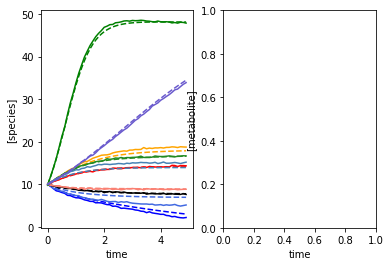

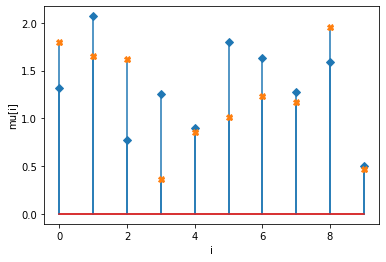

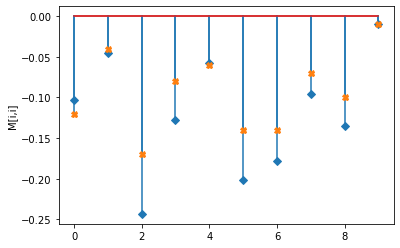

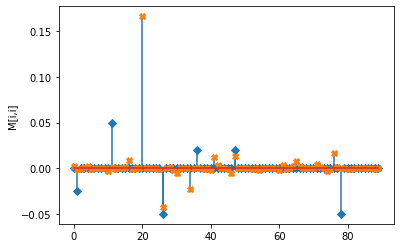

In [20]:
# plot the fit using median values of parameters

post1 = df[df.columns[7:]][0:iend].to_numpy()
est = np.median(post1,axis=0)

# fill mu_h
#mu_h = mu # if mu is fixed
mu_h = est[0:num_species]
est = est[num_species:]

# fill M_h
M_h = np.zeros([num_species,num_species])
#np.fill_diagonal(M_h, M.diagonal() ) # if Md fixed
np.fill_diagonal(M_h, -est[0:num_species])
est = est[num_species:]

count = 0
#print("est:", est)
for i in range(num_species):
    for j in range(num_species):
        if i != j:
            #M_h[i,j] = est[2*num_species + count]
            #M_h[i,j] = est[num_species + count]
            M_h[i,j] = est[count]
            count = count + 1

#print(mu_h)
#print(M_h)

# make the plot and comparison
predictor = gMLV_sim(num_species=num_species,
                     num_metabolites=num_metabolites,
                     M=M_h,
                     mu=mu_h)
yobs_h, sobs_h, _, _, _, _ = predictor.simulate(times=times, sy0=np.hstack((init_species, init_metabolites)))

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu=(mu,mu_h), M=(M, M_h))

[]
[]
[]
[]
[]
(20, 94)
[False  True  True  True  True  True  True False False  True False False
  True  True False False False False False  True False False False False
 False False False False False False False False False False  True False
 False False False False False False  True False False False  True False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False  True  True False False False False False False
 False False False False False False False False False False]
[ 1  2  3  4  5  6  9 12 13 19 34 42 46 61 76 77]
(20, 16)


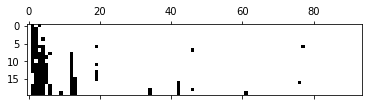

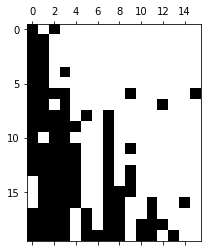